# SysArmy - Análisis de encuesta 2020.02

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
%load_ext nb_black

csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/release/2021.01/data/csv/argentina/2021.01.csv"

dataset_metadata = {
    "year": 2021,
    "part": 1,
    "skiprows": 0,
    "publish_date": "2021-02-01",
    "minimum_salary": 20587,  # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina
}

<IPython.core.display.Javascript object>

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt

raw_dataframe = None
source = requests.get(
    csv_url.format(dataset_metadata["year"], dataset_metadata["part"])
).content
raw_dataframe = pd.read_csv(
    io.StringIO(source.decode("utf-8")),
    skiprows=dataset_metadata["skiprows"],
    thousands=".",
    decimal=",",
)

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (
    raw_dataframe.columns.str.strip()
    .str.lower()
    .str.replace(regex_white_chars, "_")
    .str.replace(regex_non_alphanum, "")
    .str.translate(
        "ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})
    )
)

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

dataframe = raw_dataframe.copy()

display([column for column in dataframe.columns])

['estoy_trabajando_en',
 'donde_estas_trabajando',
 'tipo_de_contrato',
 'salario_mensual_o_retiro_bruto_en_tu_moneda_local',
 'salario_mensual_o_retiro_neto_en_tu_moneda_local',
 'pagos_en_dolares',
 'cual_fue_el_ultimo_valor_de_dolar_que_tomaron',
 'que_tan_conforme_estas_con_tu_sueldo',
 'como_crees_que_esta_tu_sueldo_con_respecto_al_ultimo_semestre',
 'recibis_algun_tipo_de_bono',
 'a_que_esta_atado_el_bono',
 'tuviste_ajustes_por_inflacion_durante_2020',
 'de_que_fue_el_ajuste_total',
 'en_que_mes_fue_el_ultimo_ajuste',
 'trabajo_de',
 'anos_de_experiencia',
 'anos_en_la_empresa_actual',
 'anos_en_el_puesto_actual',
 'gente_a_cargo',
 'plataformas',
 'lenguajes_de_programacion_o_tecnologias',
 'frameworksherramientas_y_librerias',
 'bases_de_datos',
 'qa_testing',
 'ides',
 'cantidad_de_personas_en_tu_organizacion',
 'actividad_principal',
 'la_recomendas_como_un_buen_lugar_para_trabajar',
 'como_calificas_las_politicas_de_diversidad_e_inclusion',
 'beneficios_extra',
 'salir_o_se

<IPython.core.display.Javascript object>

### 1.3. Echamos un vistazo al dataframe previo a sanitizarlo

In [3]:
raw_dataframe.T.head()

,0,1,2,3,4,5,6,7,8,9,...,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457
estoy_trabajando_en,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,...,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina,Argentina
donde_estas_trabajando,Córdoba,Córdoba,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Mendoza,Santa Fe,Ciudad Autónoma de Buenos Aires,...,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Córdoba,Santa Fe,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires,Ciudad Autónoma de Buenos Aires
tipo_de_contrato,Full-Time,Remoto (empresa de otro país),Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,...,Tercerizado (trabajo a través de consultora o ...,Full-Time,Full-Time,Remoto (empresa de otro país),Full-Time,Full-Time,Full-Time,Full-Time,Full-Time,Full-Time
salario_mensual_o_retiro_bruto_en_tu_moneda_local,115000,512000,148000,115620,47300,100000,214600,45000,150000,272000,...,109000,47000,100953,480000,130000,105000,129000,200000,138000,165000
salario_mensual_o_retiro_neto_en_tu_moneda_local,90000,512000,109000,NaN,39259,91713,137700,38500,110000,150000,...,90000,40000,83791,NaN,90000,90000,92000,141000,117000,125000


<IPython.core.display.Javascript object>

### 1.4. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [4]:
import re


def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (
            df_out[column_name].str.strip().str.replace(compiled_regex, pattern)
        )

    # debug
    total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    display("reduced in {:02f}".format((total - final) / total))
    return df_out

<IPython.core.display.Javascript object>

#### 1.4.1. Carreras

In [5]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "carrera",
    {
        "(Derecho|Abogac[íi]a|abogad.)": "Derecho",
        "(Contador.*)": "Contador Público",
        "(Arquitect(o|a|ura))": "Arquitectura",
        "(Lic.*)?Psicolog[íi]a": "Licenciatura en Psicología",
        "(Lic.*)?Marketing": "Licenciatura en Marketing",
        ".*Comunicación": "Licenciatura en Comunicación",
        "Letras": "Licenciatura en Letras",
        "Tec.*Infraestructuras{0,2}": "Tecnicatura Superior en Soporte de Infraestructuras",
        "(lic.*qu[ií]mica)": "Licenciatura en Química",
        "^(RRHH|Trabajo)": "Licenciatura en Relaciones del Trabajo",
        "(Lic.*)?Administraci[oó]n( de empresas)?": "Licenciatura en Administración de Empresas",
        "Ed.*f[ií]sica": "Educación Física",
        "Licenciatura en Cienciasdela Computación": "Licenciatura en Ciencias de la Computación",
        "Licenciatura en Ciencias dela Computación": "Licenciatura en Ciencias de la Computación",
        "(ningun(a|o)|-)": "DELETEME",
        "Lic.* Matemáticas?": "Licenciatura en Matemática",
        "(lic.*)econom[íi]a": "Licenciatura en Economía",
        "ingenier[íi]a de sistemas": "Ingeniería en Sistemas",
        "^(.*)\.$": "\\1",
    },
)

df = dataframe["carrera"].value_counts(sort=True)
display(df[:55])

'reduced in 0.113821'

Ingeniería en Sistemas de Información                  553
Ingeniería en Informática                              352
Analista de Sistemas                                   285
Licenciatura en Sistemas de Información                187
Licenciatura en Ciencias de la Computación             174
Licenciatura en Informática                            133
Tecnicatura en Programación                             98
Tecnicatura Superior en Programación                    90
Ingeniería Electrónica                                  89
Diseño Gráfico                                          67
Tecnicatura en Informática                              64
Ingeniería en Computación                               60
Licenciatura en Análisis de Sistemas                    52
Licenciatura en Administración de Empresas              49
Analista Programador Universitario                      33
Analista Programador                                    31
Tecnicatura Superior en Análisis de Sistemas            

<IPython.core.display.Javascript object>

#### 1.4.2. Universidades

In [6]:
# En Mendoza se asocia UM a la Universidad de Mendoza, y en Buenos Aires, a la Universidad de Morón
mask = dataframe.eval(
    'universidad in ["UM", "Um"] and donde_estas_trabajando == "Mendoza"'
)
dataframe.universidad.loc[mask] = "Universidad Nacional de Mendoza"
display(dataframe[mask].universidad)

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Series([], Name: universidad, dtype: object)

<IPython.core.display.Javascript object>

In [7]:
dataframe = normalize_dataframe_column(
    dataframe,
    "universidad",
    {
        "(UNSJ|.*Nacional de San Juan)": "UNSJ - Universidad Nacional de San Juan",
        "IRSO": "IRSO - Instituto Raúl Scalabrini Ortíz",
        "(UNPSJB|.*Patagonia San Juan Bosco.*)": "UNPSJB - Universidad Nacional de la Patagonia San Juan Bosco",
        "(UNSL|Universidad Nacional de San Luis)": "UNSL - Universidad Nacional de San Luis",
        "IFTS18": "IFTS18 - Instituto de Formación Técnica Superior N°18",
        "UCASAL": "UCASAL - Universidad Católica de Salta",
        "Universidad de Mendoza": "UM - Universidad de Mendoza",
        "UNTREF": "UNTREF - Universidad Nacional de Tres de Febrero",
        "(UNL[uU]|Universidad Nacional de Luj[aá]n)": "UNLu - Universidad Nacional de Luján",
        "(UAA|.*Atl[aá]ntida.*)": "UAA - Universidad Atlántida Argentina",
        "([fF]?IUPFA)": "IUPFA - Instituto Universitario de la Policía Federal Argentina",
        "([uU]?FASTA)": "FASTA - Fraternidad de Agrupaciones Santo Tomás de Aquino",
        "(UCSE)": "UCSE - Universidad Católica de Santiago del Estero",
        "(ISIV|.*Virasoro.*)": "ISIV - Instituto Superior de Informática Virasoro",
        "(UN[Aa]M)": "UNaM - Universidad Nacional de Misiones",
        "(-|ninguna)$": "DELETEME",
    },
)

df = dataframe["universidad"].value_counts(sort=True)
display(df[:60])

'reduced in 0.090726'

UTN - Universidad Tecnológica Nacional                                        682
UBA - Universidad de Buenos Aires                                             428
UADE - Universidad Argentina De la Empresa                                    123
UNLaM - Universidad Nacional de La Matanza                                     96
UNLP - Universidad Nacional de La Plata                                        89
UAI - Universidad Abierta Interamericana                                       88
UNC - Universidad Nacional de Córdoba                                          80
UP - Universidad de Palermo                                                    64
Universidad Siglo 21                                                           49
Escuela Da Vinci                                                               43
UNR - Universidad Nacional de Rosario                                          42
ORT                                                                            40
UCAECE - Centro 

<IPython.core.display.Javascript object>

#### 1.4.3. Experiencia

In [8]:
dataframe["anos_de_experiencia"] = dataframe["anos_de_experiencia"].astype(int)
dataframe["anos_en_la_empresa_actual"] = dataframe["anos_en_la_empresa_actual"].astype(
    int
)
dataframe["anos_en_el_puesto_actual"] = dataframe["anos_en_el_puesto_actual"].astype(
    int
)

<IPython.core.display.Javascript object>

#### 1.4.4. Regiones

In [9]:
dataframe = normalize_dataframe_column(
    dataframe,
    "donde_estas_trabajando",
    {"(GBA|Provincia de Buenos Aires)": "Buenos Aires",},
)

display(dataframe["donde_estas_trabajando"].unique())

'reduced in 0.040000'

array(['Córdoba', 'Ciudad Autónoma de Buenos Aires', 'Mendoza',
       'Santa Fe', 'Buenos Aires', 'Río Negro', 'Entre Ríos', 'San Juan',
       'Jujuy', 'Tucumán', 'Salta', 'Chaco', 'Corrientes', 'Misiones',
       'Neuquén', 'Formosa', 'La Rioja', 'San Luis', 'Chubut',
       'Santiago del Estero', 'Tierra del Fuego', 'Santa Cruz',
       'Catamarca', 'La Pampa'], dtype=object)

<IPython.core.display.Javascript object>

#### 1.4.5. Discapacidad

In [10]:
dataframe = normalize_dataframe_column(
    dataframe,
    "tenes_algun_tipo_de_discapacidad",
    {
        "^(_|-|no( tengo)?|ningun[oa]|nada|0|ni)$": None,
        ".*auditiv[oa].*": "Auditiva",
        ".*visual.*": "Visual",
        "mental": "Mental",
        "motriz": "Motriz",
        "vis?ceral": "Visceral",
    },
)

df = dataframe["tenes_algun_tipo_de_discapacidad"].value_counts(sort=True)
display(df[:6])

'reduced in 0.339623'

Visual                       126
Auditiva                      22
Motriz                        16
Visceral                       9
Mental                         8
Ninguna de las anteriores      2
Name: tenes_algun_tipo_de_discapacidad, dtype: int64

<IPython.core.display.Javascript object>

#### 1.4.5. Roles

In [11]:
dataframe = normalize_dataframe_column_replace(
    dataframe,
    "trabajo_de",
    {
        "Project Manager.*": "Project Manager",
        "Director, Product Manager, Project Manager": "Manager / Director",
        "Technical Leader.*": "Technical Leader",
        "Team Leader.*": "Technical Leader",
        "Full ?Stack Developer": "Developer",
        "Seguridad Inform[aá]tica": "Infosec",
        "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
        "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
        "Software Engineer": "Developer",
        "(Analista )?programador": "Developer",
        "Analista Funcional": "Functional Analyst",
        "Technical Functional Analyst": "Functional Analyst",
        "administrativo": "Administrativo",
        "^cto.*": "CTO",
        "Asistant": "Assistant",
        "helpdesk": "HelpDesk",
        "(Analista de seguridad|Security.*)": "Infosec",
        "BI Leader": "BI Analyst / Data Analyst",
    },
)

df = dataframe["trabajo_de"].value_counts(sort=True)
display(df[0:50])

'reduced in 0.061798'

Developer                    2401
SysAdmin / DevOps / SRE       631
Technical Leader              388
QA / Tester                   258
Manager / Director            255
HelpDesk                      243
Project Manager               170
Consultant                    137
BI Analyst / Data Analyst     133
Architect                     133
Business Analyst              120
Networking                    112
Infosec                       100
Data Scientist                 97
Data Engineer                  92
UX                             82
Recruiter / HR                 70
Product Manager                63
DBA                            47
Scrum Master                   37
Designer                       35
Sales / Pre-Sales              32
VP / C-Level                   29
Finance                        17
Functional Analyst             16
Middleware                     13
Technical Support              11
Storage / Backup                8
Technical Writer                7
Docente       

<IPython.core.display.Javascript object>

#### 1.4.6. Salario (corrección de numeración)

In [12]:
# Algunos salarios están cargados, pareciera ser, en miles

<IPython.core.display.Javascript object>

#### 1.4.7. Sueldo dolarizado

In [13]:
mask = dataframe["pagos_en_dolares"].str.contains("", na=False)
column_name = "sueldo_dolarizado"

dataframe.loc[~mask, column_name] = False
dataframe.loc[mask, column_name] = True
dataframe.loc[:, column_name] = dataframe["sueldo_dolarizado"].astype(bool)

<IPython.core.display.Javascript object>

### 1.5. Agregamos columnas calculadas

In [14]:
dataframe["seniority"] = pd.cut(
    dataframe["anos_de_experiencia"].values,
    [-1, 2, 5, 50],
    labels=["Junior", "Semi-Senior", "Senior"],
)
display(dataframe["seniority"])

0            Senior
1            Senior
2            Senior
3       Semi-Senior
4            Junior
           ...     
6453         Junior
6454         Senior
6455         Senior
6456         Senior
6457         Junior
Name: seniority, Length: 6088, dtype: category
Categories (3, object): ['Junior' < 'Semi-Senior' < 'Senior']

<IPython.core.display.Javascript object>

### 1.6. Eliminamos outliers

In [15]:
salary_debug_columns = [
    "tengo",
    "anos_de_experiencia",
    "estoy_trabajando_en",
    "tipo_de_contrato",
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
]


def remove_outlier(df_in, col_name, iqr_factor=1.5):
    """
  IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
  accept a dataframe, remove outliers, return cleaned data in a new dataframe
  see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
  """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    df_inliers = df_in.loc[
        (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    ]
    df_outliers = df_in.loc[
        (df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)
    ]
    return df_inliers, df_outliers

<IPython.core.display.Javascript object>

#### 1.6.1. Salarios

In [16]:
dataframe["salario_mensual_o_retiro_bruto_en_tu_moneda_local"] = (
    dataframe["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .str.replace(",", "")
    .str.replace(".", "")
    .str.replace("$", "")
    .str.replace(r"\D", "0")
    .str.extract("(\d+)", expand=False)
    .fillna(0)
    .astype(float)
)

df_inliers, df_outliers = remove_outlier(
    dataframe, "salario_mensual_o_retiro_bruto_en_tu_moneda_local", 3.5
)

# inliers percent over total
display(len(df_inliers) / len(dataframe))

# display outliers
display(df_outliers[salary_debug_columns])

0.9538436268068331

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_o_retiro_bruto_en_tu_moneda_local
54,30,1,Argentina,Full-Time,11341059.0
60,30,3,Argentina,Full-Time,6798012.0
76,33,1,Argentina,Full-Time,4780992.0
78,27,9,Argentina,Full-Time,1550000.0
124,38,17,Argentina,Full-Time,5592146.0
...,...,...,...,...,...
6214,31,5,Argentina,Full-Time,8665067.0
6247,41,21,Argentina,Full-Time,30422134.0
6296,26,5,Argentina,Remoto (empresa de otro país),800000.0
6359,24,5,Argentina,Full-Time,200000000.0


<IPython.core.display.Javascript object>

In [17]:
minimum_salary = dataset_metadata["minimum_salary"]
df_outliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local < @minimum_salary/2.0"
)
display(len(df_outliers_lower_limit))
display(df_outliers_lower_limit[salary_debug_columns])
df_inliers_lower_limit = df_inliers.query(
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local >= @minimum_salary/2.0"
)

dataframe = df_inliers_lower_limit

228

,tengo,anos_de_experiencia,estoy_trabajando_en,tipo_de_contrato,salario_mensual_o_retiro_bruto_en_tu_moneda_local
38,23,0,Argentina,Full-Time,552.0
43,24,1,Argentina,Participación societaria en una cooperativa,85.0
75,25,4,Argentina,Full-Time,90.0
94,37,3,Argentina,Remoto (empresa de otro país),2500.0
120,39,19,Argentina,Full-Time,1457.0
...,...,...,...,...,...
6368,27,5,Argentina,Full-Time,65.0
6374,40,12,Argentina,Full-Time,63.0
6393,37,7,Argentina,Full-Time,47.0
6394,40,20,Argentina,Freelance,46.0


<IPython.core.display.Javascript object>

### 1.7 Helper functions

In [18]:
def invert_non_representative_values(
    dataframe,
    column,
    representative_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    df.loc[
        df.eval("{} not in @representative_values".format(column)), value_column
    ] *= -1
    return df


def filter_valid_top_values(
    dataframe,
    column,
    top_values,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    return dataframe.query(
        '{} in @top_values & {} != "DELETEME"'.format(column, column)
    )


def get_two_dimensional_median_with_outliers_filtered(
    dataframe,
    group_by_columns,
    value_column="salario_mensual_o_retiro_bruto_en_tu_moneda_local",
):
    """
  Given a dataframe, groups data by the first given column in group_by_columns, computes median
  and sets to zero all values that have less than 5% of representation on the second column
  """
    dfl = (
        dataframe.groupby(group_by_columns)
        .size()
        .to_frame()
        .groupby(level=0)
        .apply(lambda x: x / float(x.sum()))
        .rename(columns={0: "population"})
        .query("population > 0.05")
        .drop(columns=["population"])
        .reset_index()
    )
    dfr = (
        dataframe.groupby(group_by_columns)
        .median()[value_column]
        .fillna(0)
        .to_frame()
        .reset_index()
    )
    return (
        pd.merge(dfl, dfr, on=group_by_columns, how="inner")
        .groupby(group_by_columns)
        .min()
        .unstack(group_by_columns[1])[value_column]
        .fillna(0)
    )

<IPython.core.display.Javascript object>

## 2. Análisis de resultados

Análisis exploratorio de los datos, los resultados se exportan en un JSON llamado 'charts'

In [19]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(dataframe),
}

display(charts)


def to_rechart(df, max=0):
    """
  if max is set, groups the exceeded rows into 'Otros' column, summing values
  """
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

{'total_surveyed': 6088, 'total_analyzed_surveyed': 5579}

<IPython.core.display.Javascript object>

### 2.1. Perfiles

#### 2.1.1. Regiones

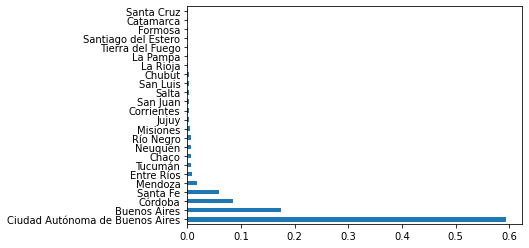

<IPython.core.display.Javascript object>

In [20]:
df = dataframe["donde_estas_trabajando"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["regions_percent"] = to_rechart(df)

#### 2.1.2. Roles (Posición, Open Source, Hobbie)

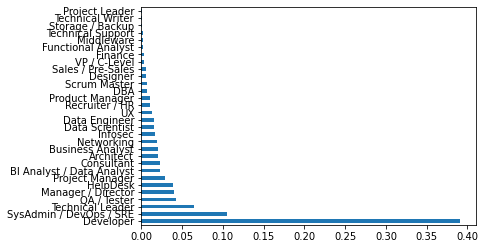

<IPython.core.display.Javascript object>

In [21]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)

df[:30].plot.barh()
charts["roles_percent"] = to_rechart(df, 30)

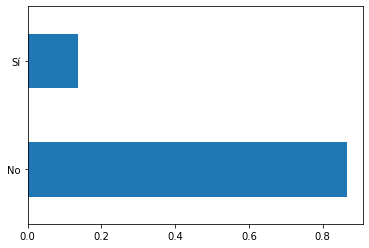

<IPython.core.display.Javascript object>

In [22]:
df = dataframe["contribuis_a_proyectos_open_source"].value_counts(
    normalize=True, sort=True
)

df.plot.barh()
charts["opensource_percent"] = to_rechart(df)

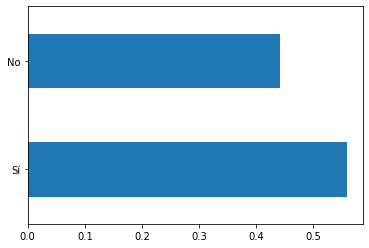

<IPython.core.display.Javascript object>

In [23]:
df = dataframe["programas_como_hobbie"].value_counts(normalize=True, sort=True)

df.plot.barh()
charts["hobbie_percent"] = to_rechart(df)

#### 2.1.3. Experiencia

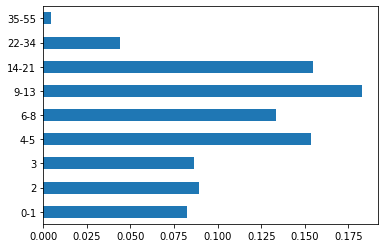

<IPython.core.display.Javascript object>

In [24]:
df = dataframe["anos_de_experiencia"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34", "35-55"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_percent"] = to_rechart(df.sort_index())

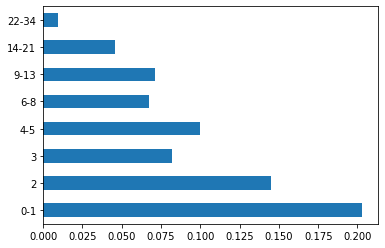

<IPython.core.display.Javascript object>

In [25]:
df = dataframe["anos_en_la_empresa_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_company"] = to_rechart(df.sort_index())

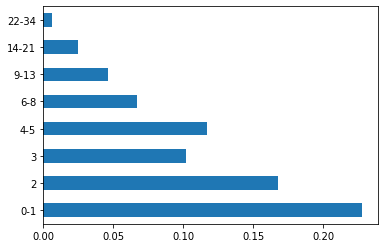

<IPython.core.display.Javascript object>

In [26]:
df = dataframe["anos_en_el_puesto_actual"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34],
        labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-34"],
    )
).count() / len(df)

df.plot.barh()
charts["experience_years_in_position"] = to_rechart(df.sort_index())

#### 2.1.4. Educación

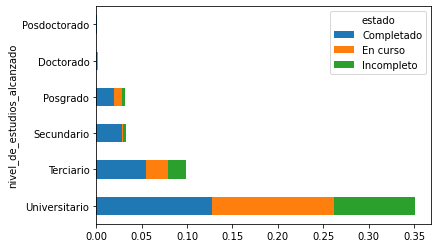

<IPython.core.display.Javascript object>

In [27]:
df = dataframe.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    dataframe
)

df.plot(kind="barh", stacked=True, logx=False)
charts["education_stacked"] = to_rechart(df)

27.895

Index(['Ingeniería en Sistemas de Información', 'Ingeniería en Informática',
       'Analista de Sistemas', 'Licenciatura en Sistemas de Información',
       'Licenciatura en Ciencias de la Computación',
       'Licenciatura en Informática', 'Tecnicatura en Programación',
       'Tecnicatura Superior en Programación', 'Ingeniería Electrónica',
       'Tecnicatura en Informática', 'Diseño Gráfico',
       'Ingeniería en Computación', 'Licenciatura en Análisis de Sistemas',
       'Licenciatura en Administración de Empresas',
       'Tecnicatura Superior en Análisis de Sistemas',
       'Analista Programador Universitario', 'Analista Programador',
       'Analista Universitario de Sistemas',
       'Tecnicatura Superior en Sistemas Informáticos',
       'Ingeniería en Telecomunicaciones', 'Ingeniería en Software',
       'Analista de Computación', 'Telecomunicaciones',
       'Licenciatura en Psicología', 'Ingeniería Industrial',
       'Tecnicatura en Sistemas', 'Tecnicatura en Computac

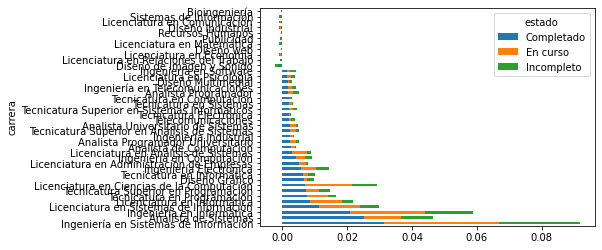

<IPython.core.display.Javascript object>

In [28]:
# Para el grado de completitud por carrera se tendrá en cuenta el tamaño de la muestra, se considerarán insuficientes los datos de aquellas carreras que representen menos del 0.5% del total

df = (
    dataframe["carrera"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("carrera > 0.005")
)

display(len(dataframe["carrera"]) * 0.005)
chosen_careers = df.index
display(chosen_careers)

df = dataframe.query('carrera != "DELETEME"')["carrera"].value_counts(
    normalize=True, sort=True
)
charts["careeres_percent"] = to_rechart(df, 40)

df = dataframe.query('carrera != "DELETEME"').groupby(["carrera", "estado"])[
    "carrera"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df.loc[
    df.eval("carrera not in @chosen_careers"), ["Completado", "En curso", "Incompleto"]
] *= -1

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["careeres_stacked_percent"] = to_rechart(df[:40])

/home/nad/.pyenv/versions/system-3.8.5/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


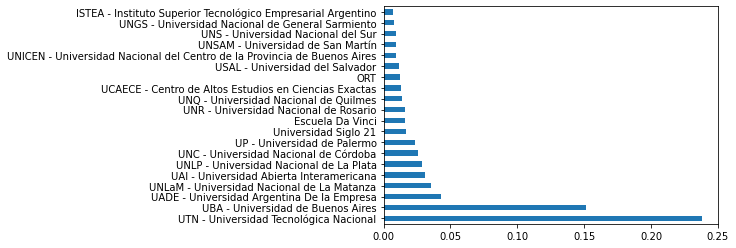

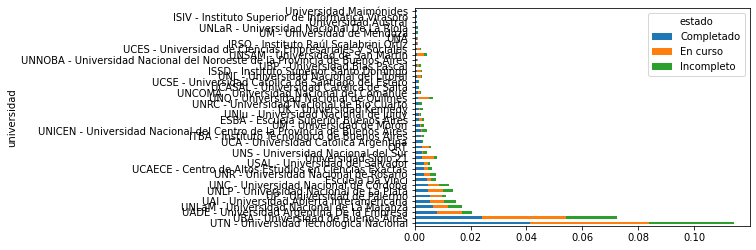

<IPython.core.display.Javascript object>

In [29]:
df = dataframe.query('universidad != "DELETEME"')["universidad"].value_counts(
    normalize=True, sort=True
)

df[:20].plot(kind="barh")
charts["universities_percent"] = to_rechart(df, 40)

df = dataframe.query('universidad != "DELETEME"').groupby(["universidad", "estado"])[
    "universidad"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado", "En curso"], ascending=False
) / len(
    dataframe
)

df[:40].plot(kind="barh", stacked=True, logx=False)
charts["universities_stacked_percent"] = to_rechart(df, 40)

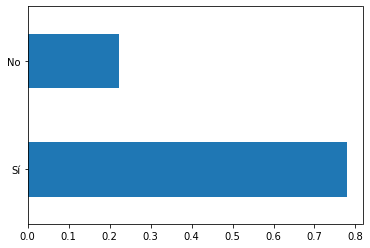

<IPython.core.display.Javascript object>

In [30]:
dc = pd.DataFrame(
    {
        "realizaste_cursos_de_especializacion": dataframe[
            "realizaste_cursos_de_especializacion"
        ].dropna()
    }
)
dc

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = dc["hizo_curso"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_percent"] = to_rechart(df)

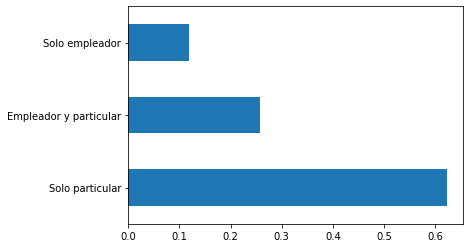

<IPython.core.display.Javascript object>

In [31]:
mask_empleador = dc["realizaste_cursos_de_especializacion"].str.contains("un empleador")
mask_particular = dc["realizaste_cursos_de_especializacion"].str.contains(
    "de forma particular"
)

dc.loc[mask_particular, "quien_paga"] = "Solo particular"
dc.loc[mask_empleador, "quien_paga"] = "Solo empleador"
dc.loc[mask_empleador & mask_particular, "quien_paga"] = "Empleador y particular"

df = dc["quien_paga"].value_counts(normalize=True, sort=True)

df.plot(kind="barh")
charts["specialization_pays_percent"] = to_rechart(df)

#### 2.1.5. Demografía

'reduced in 0.052632'

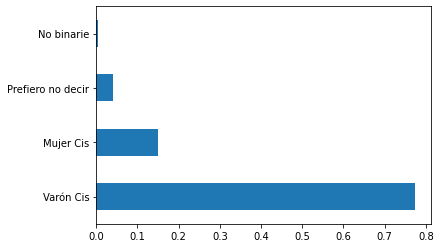

<IPython.core.display.Javascript object>

In [32]:
dataframe = normalize_dataframe_column_replace(
    dataframe, "me_identifico", {"Hombre": "Varón Cis"}
)

df = dataframe["me_identifico"].value_counts(normalize=True, sort=True)

df[:4].plot(kind="barh")
charts["demographics_gender_percent"] = to_rechart(df, max=4)

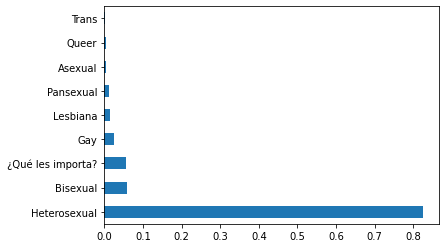

<IPython.core.display.Javascript object>

In [33]:
df = dataframe["identidad_sexual"].value_counts(normalize=True, sort=True)

df[:10].plot(kind="barh")
charts["demographics_sexual_orientation_percent"] = to_rechart(df, 10)

### 2.2. Salarios

#### 2.2.1. Progresión Histórica

https://github.com/openqube/openqube-sueldos/blob/release/2021.01/pipeline/historical-data-analysis.ipynb

#### 2.2.2. Región

In [34]:
# Para el análisis regional se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas regiones que representen menos del 0.5% del total

df = (
    dataframe["donde_estas_trabajando"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("donde_estas_trabajando > 0.005")
)

display(len(dataframe["donde_estas_trabajando"]) * 0.005)
chosen_regions = df.index
display(chosen_regions)

27.895

Index(['Ciudad Autónoma de Buenos Aires', 'Buenos Aires', 'Córdoba',
       'Santa Fe', 'Mendoza', 'Entre Ríos', 'Tucumán', 'Chaco', 'Neuquén',
       'Río Negro', 'Misiones'],
      dtype='object')

<IPython.core.display.Javascript object>

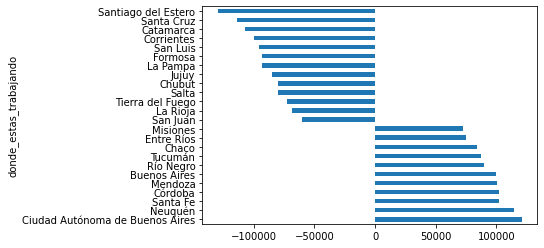

<IPython.core.display.Javascript object>

In [35]:
# Éstas serán convertidas a valores negativos, de manera de poder distinguirlas sin perjudicar a quienes deseen
# observar los resultados más allá del tamaño muestral acotado

df = dataframe.copy()

df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_median"] = to_rechart(df)

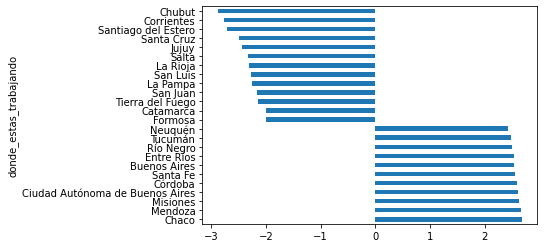

<IPython.core.display.Javascript object>

In [36]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "que_tan_conforme_estas_con_tu_sueldo",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .mean()
    .unstack()["que_tan_conforme_estas_con_tu_sueldo"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["regions_salary_acquiescence"] = to_rechart(df)

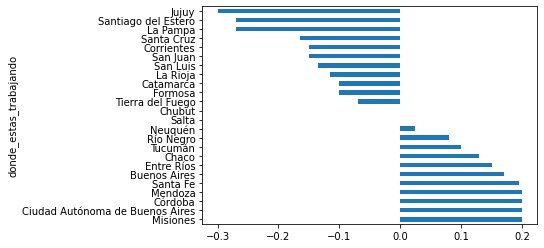

<IPython.core.display.Javascript object>

In [37]:
df = dataframe.copy()
df.loc[
    df.eval("donde_estas_trabajando not in @chosen_regions"),
    "de_que_fue_el_ajuste_total",
] *= -1
df = (
    df.groupby(["donde_estas_trabajando"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["regions_salary_adjustment"] = to_rechart(df)

##### 2.2.2.1. Región (mínimos por seniority) - no incluídos en el reporte

In [38]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .min()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Río Negro,38000.0,51877.0,54650.0
Neuquén,25000.0,68000.0,50000.0
Entre Ríos,25000.0,80000.0,45000.0
Tucumán,25000.0,59967.0,41428.0
Córdoba,20000.0,15000.0,34150.0
Chaco,20000.0,30000.0,34000.0
Mendoza,20000.0,35000.0,30000.0
Misiones,22000.0,22000.0,30000.0
Santa Fe,11000.0,14750.0,24000.0


<IPython.core.display.Javascript object>

##### 2.2.2.2. Región (máximos por seniority) - no incluídos en el reporte

In [39]:
df = (
    dataframe.query("donde_estas_trabajando in @chosen_regions")
    .groupby(["donde_estas_trabajando", "seniority"])[
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
    ]
    .max()
    .unstack()
    .sort_values(by=["Senior"], ascending=False)
)
display(df)

seniority,Junior,Semi-Senior,Senior
donde_estas_trabajando,,,
Buenos Aires,250000.0,514800.0,536000.0
Chaco,147000.0,181000.0,533000.0
Ciudad Autónoma de Buenos Aires,400000.0,530000.0,530000.0
Santa Fe,374215.0,514000.0,530000.0
Río Negro,124900.0,170000.0,525000.0
Córdoba,440000.0,530000.0,512000.0
Mendoza,164000.0,450000.0,450000.0
Entre Ríos,100000.0,180000.0,425000.0
Neuquén,120000.0,514299.0,285000.0


<IPython.core.display.Javascript object>

#### 2.2.3. Puesto

##### 2.2.3.1. Seniority

(metodología vieja, queda sólo para reproducir reportes previos)

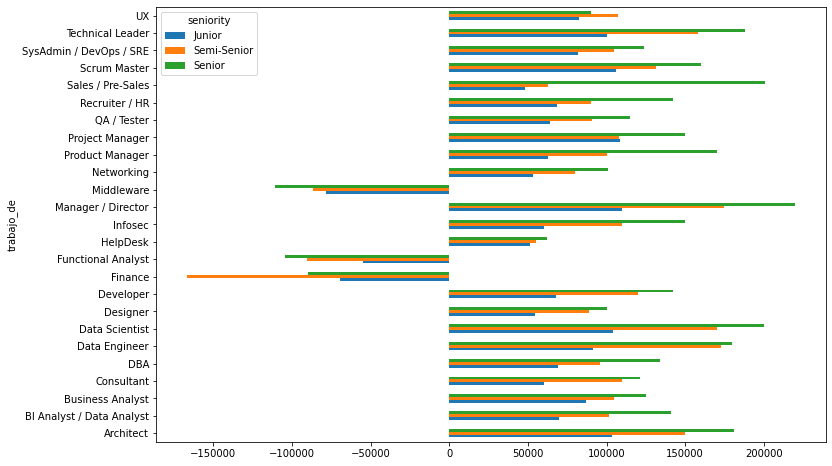

<IPython.core.display.Javascript object>

In [40]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total

df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

chosen_roles = list(df.index)
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities

df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
candidate_roles = list(df[:26].index)
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Seniority

La metodología previa consideraba a una `position` con "suficientes datos" si la sumatoria de todas sus seniorities (junior, senior, semisr) contenía al menos un 0.5% del total de las respuestas.

La nueva metodología considera cada combinación (`position`, `seniority`) con suficientes datos si hay al menos 6 valores para obtener la mediana.

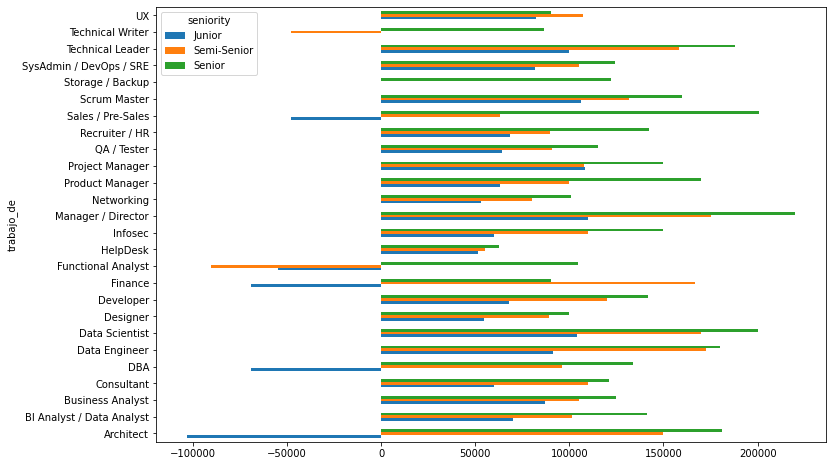

<IPython.core.display.Javascript object>

In [41]:
salary_df = dataframe.copy()[dataframe.seniority.notna()]
salary_df["position_and_seniority"] = salary_df[["trabajo_de", "seniority"]].agg(
    "__".join, axis=1
)

df = (salary_df.position_and_seniority.value_counts(sort=True).to_frame()).query(
    "position_and_seniority > 5"
)
top_positions = df.index
candidate_roles = [position.split("__")[0] for position in top_positions]
excluded_roles = {
    "VP / C-Level"
}  # Excluído porque no contaba con todas las seniorities
top_roles = [r for r in candidate_roles if r not in excluded_roles]

df = (
    salary_df.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

# invert positions and seniorities that have insufficient data.
df *= -1
for pos in top_positions:
    role = pos.split("__")[0]
    if role in excluded_roles:
        continue
    srty = pos.split("__")[1]

    df.loc[role][srty] *= -1

plt.figure(figsize=(12, 8))
df.plot(kind="barh", ax=plt.gca())
charts["roles_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.3.1. Industria

27.895

Index(['Developer', 'SysAdmin / DevOps / SRE', 'Technical Leader',
       'QA / Tester', 'Manager / Director', 'HelpDesk', 'Project Manager',
       'BI Analyst / Data Analyst', 'Consultant', 'Architect',
       'Business Analyst', 'Networking', 'Infosec', 'Data Scientist',
       'Data Engineer', 'UX', 'Recruiter / HR', 'Product Manager', 'DBA',
       'Scrum Master', 'Designer', 'Sales / Pre-Sales'],
      dtype='object')

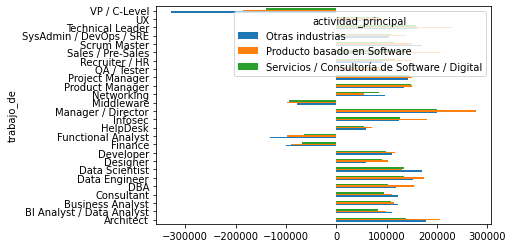

<IPython.core.display.Javascript object>

In [42]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["trabajo_de"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("trabajo_de > 0.005")
)

display(len(dataframe["trabajo_de"]) * 0.005)
chosen_roles = df.index
display(chosen_roles)


df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

df = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de", "actividad_principal"])
    .median()
    .unstack("actividad_principal")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)

df.loc[
    df.eval("trabajo_de not in @chosen_roles"),
    [
        "Otras industrias",
        "Producto basado en Software",
        "Servicios / Consultoría de Software / Digital",
    ],
] *= -1

df.plot(kind="barh")
charts["roles_actividad_principal_salary_median"] = to_rechart(df[:30])

##### 2.2.3.3. Seniority e Industria

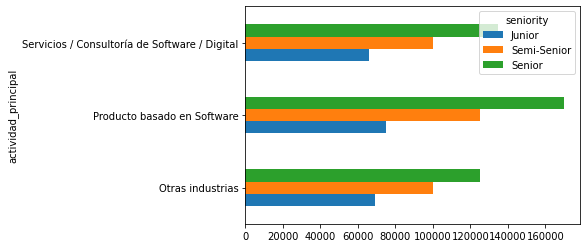

<IPython.core.display.Javascript object>

In [43]:
df = (
    dataframe.groupby(["actividad_principal", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
)  # .sort_values(by=[''],ascending=False)

df.plot.barh()
charts["actividad_principal_seniority_salary_median"] = to_rechart(df)

##### 2.2.3.2. Open source / hobbie

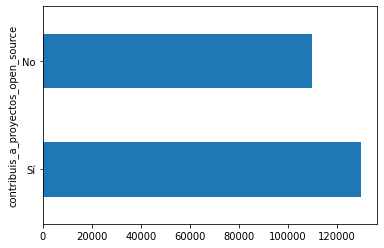

<IPython.core.display.Javascript object>

In [44]:
df = (
    dataframe.groupby(["contribuis_a_proyectos_open_source"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")
charts["opensource_salary_median"] = to_rechart(df)

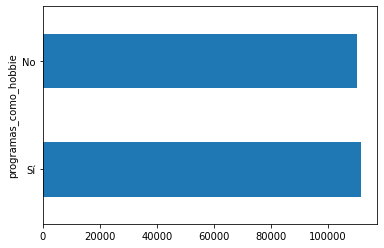

<IPython.core.display.Javascript object>

In [45]:
df = (
    dataframe.groupby(["programas_como_hobbie"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot.barh()
charts["hobbie_salary_median"] = to_rechart(df)

#### 2.2.4. Carrera

In [46]:
df = dataframe.groupby(["carrera", "estado"])["carrera"].count().unstack(
    "estado"
).fillna(0).sort_values(by=["Completado", "En curso"], ascending=False) / len(dataframe)

top_careers = df[:30].index

# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = df[:30]["Completado"].to_frame().query("Completado > 0.005")
display(df)
chosen_careers = df.index

,Completado
carrera,
Ingeniería en Sistemas de Información,0.031368
Analista de Sistemas,0.025094
Ingeniería en Informática,0.020972
Licenciatura en Sistemas de Información,0.011472
Licenciatura en Informática,0.008424
Tecnicatura en Programación,0.007707
Tecnicatura Superior en Programación,0.007349
Licenciatura en Ciencias de la Computación,0.006991
Diseño Gráfico,0.006632


<IPython.core.display.Javascript object>

##### 2.2.4.1. Según Seniority

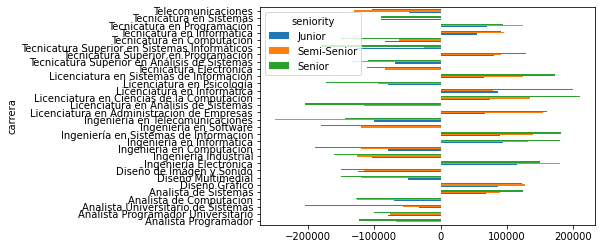

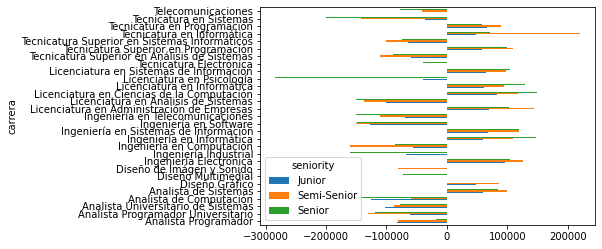

<IPython.core.display.Javascript object>

In [47]:
df = dataframe.query('estado == "Completado"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median"] = to_rechart(df[:30])


df = dataframe.query('estado == "En curso"').copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "seniority"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_seniority_salary_median_encurso"] = to_rechart(df[:30])

In [48]:
# Cuántos Ingenieros Industriales hay en el resultado obtenido, ya que sobresale del resto
df = dataframe.query('carrera in ["Ingeniería Industrial"] & estado == "Completado"')[
    ["seniority", "trabajo_de", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
].sort_values(by=["salario_mensual_o_retiro_bruto_en_tu_moneda_local"], ascending=False)

display("Un {:.2f}%".format(len(df) / len(dataframe) * 100))
display(df)

'Un 0.25%'

,seniority,trabajo_de,salario_mensual_o_retiro_bruto_en_tu_moneda_local
2616,Junior,Business Analyst,345000.0
2811,Senior,Manager / Director,320000.0
3063,Senior,Product Manager,300000.0
1143,Senior,Architect,211190.0
2750,Junior,Developer,180000.0
3917,Semi-Senior,Product Manager,175000.0
2046,Semi-Senior,BI Analyst / Data Analyst,126000.0
3205,Senior,BI Analyst / Data Analyst,110000.0
2340,Senior,Project Manager,105000.0
3336,Junior,Data Scientist,103000.0


<IPython.core.display.Javascript object>

##### 2.2.4.2. Según Estado de la Carrera

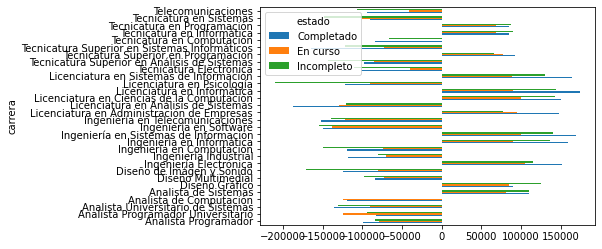

<IPython.core.display.Javascript object>

In [49]:
df = dataframe.copy()
df = invert_non_representative_values(df, "carrera", chosen_careers)
df = filter_valid_top_values(df, "carrera", top_careers)
df = get_two_dimensional_median_with_outliers_filtered(
    df, ["carrera", "estado"], "salario_mensual_o_retiro_bruto_en_tu_moneda_local"
)

df[:30].plot(kind="barh")
charts["carrera_estado_salary_median"] = to_rechart(df[:30])

##### 2.2.4.3. Según Nivel de Estudios Alcanzado

27.895

Index(['Universitario', 'Terciario', 'Secundario', 'Posgrado'], dtype='object')

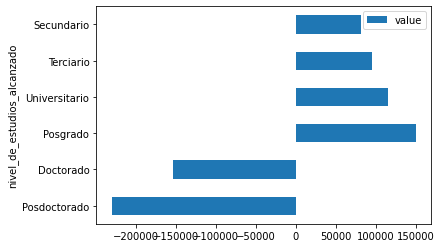

<IPython.core.display.Javascript object>

In [50]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["nivel_de_estudios_alcanzado"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
    .query("nivel_de_estudios_alcanzado > 0.005")
)

display(len(dataframe["nivel_de_estudios_alcanzado"]) * 0.005)
chosen_levels = df.index
display(chosen_levels)

df = (
    dataframe.groupby(["nivel_de_estudios_alcanzado"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
    .to_frame("value")
)
df.loc[df.eval("nivel_de_estudios_alcanzado not in @chosen_levels"), "value"] *= -1

df.plot(kind="barh")
charts["nivel_estudios_salary_median"] = to_rechart(df)

##### 2.2.4.4. Según hicieron o no Cursos de Especialización

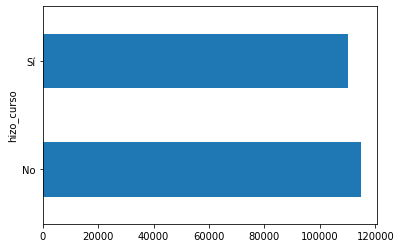

<IPython.core.display.Javascript object>

In [51]:
dc = dataframe[
    [
        "realizaste_cursos_de_especializacion",
        "salario_mensual_o_retiro_bruto_en_tu_moneda_local",
    ]
].dropna()

mask = dc["realizaste_cursos_de_especializacion"].str.contains("Sí")
dc.loc[mask, "hizo_curso"] = "Sí"
dc.loc[~mask, "hizo_curso"] = "No"

df = (
    dc.groupby(["hizo_curso"])
    .median()
    .unstack()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .sort_values(ascending=False)
)

df.plot(kind="barh")

charts["hizo_curso_salary_median"] = to_rechart(df)

#### 2.2.5. Tecnología

##### 2.2.5.1. Según Plataformas

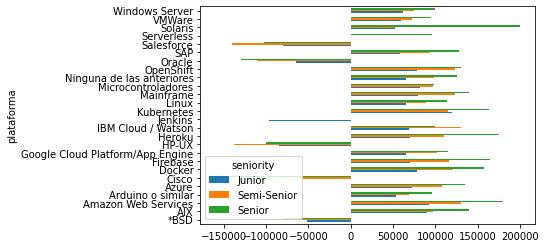

<IPython.core.display.Javascript object>

In [52]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)

top_platforms = df[:30].index
excluded_platforms = {"OpenStack"}  # Excluída para mantener escala
chosen_platforms = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["plataformas"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["plataformas"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="plataforma",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("plataforma in @top_platforms")
    .query("plataforma not in @excluded_platforms")
    .groupby(["plataforma", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("plataforma not in @chosen_platforms"), ["Junior", "Semi-Senior", "Senior"]
] *= -1

df[:30].plot(kind="barh")
charts["plataformas_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.5.2. Según Lenguajes de Programación

seniority,Junior,Semi-Senior,Senior
lenguajes_de_programacion_o_tecnologias,,,
.NET,63000.0,100000.0,136000.0
ABAP,-62500.0,-114000.0,-147000.0
Arduino,-42000.0,-84066.0,-97025.0
Assembler,-80000.0,-85000.0,-105500.0
Bash/Shell,83000.0,125000.0,150000.0
C,73000.0,114000.0,150000.0
C#,58628.5,87175.0,150000.0
C++,70000.0,89731.0,127000.0
COBOL,-62000.0,-115000.0,-137500.0


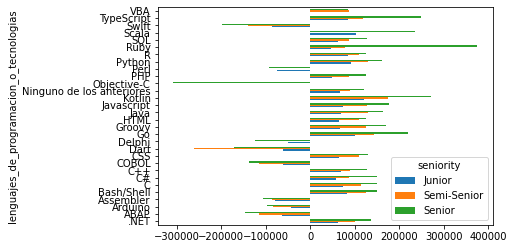

<IPython.core.display.Javascript object>

In [53]:
# Para este análisis se tendrá en cuenta el tamaño de la muestra, se marcarán como insuficientes los datos de aquellas que representen menos del 0.5% del total
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<count>[^,]+),? ?")["count"]
    .value_counts(normalize=True, sort=True)
)
top_languages = df[:30].index

chosen_languages = df.to_frame().query("count > 0.005").index

df = dataframe.copy()
df = (
    df["lenguajes_de_programacion_o_tecnologias"]
    .str.split(",")
    .apply(pd.Series)
    .merge(df, right_index=True, left_index=True)
    .drop(["lenguajes_de_programacion_o_tecnologias"], axis=1)
    .melt(
        id_vars=["seniority", "salario_mensual_o_retiro_bruto_en_tu_moneda_local"],
        value_name="lenguajes_de_programacion_o_tecnologias",
    )
    .drop(["variable"], axis=1)
    .dropna()
    .query("lenguajes_de_programacion_o_tecnologias in @top_languages")
    .groupby(["lenguajes_de_programacion_o_tecnologias", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)

df.loc[
    df.eval("lenguajes_de_programacion_o_tecnologias not in @chosen_languages"),
    ["Junior", "Semi-Senior", "Senior"],
] *= -1

display(df)
df.plot(kind="barh")
charts["lenguajes_de_programacion_seniority_salary_median"] = to_rechart(df[:30])

##### 2.2.6. Otras compensaciones

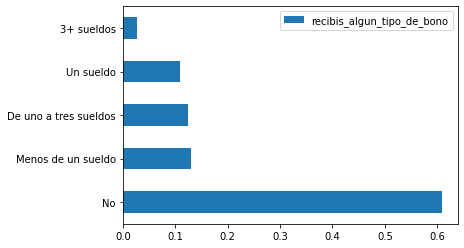

<IPython.core.display.Javascript object>

In [54]:
df = (
    dataframe["recibis_algun_tipo_de_bono"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["bonos_percent"] = to_rechart(df)

#### 2.2.6. Tipo de contrato

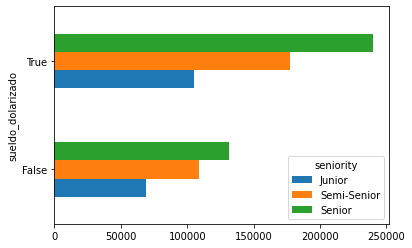

<IPython.core.display.Javascript object>

In [55]:
df = (
    dataframe.groupby(["sueldo_dolarizado", "seniority"])
    .median()
    .unstack("seniority")["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
)  # .sort_values(by=['salario_mensual_bruto_en_tu_moneda_local'], ascending=False)
df.plot(kind="barh")
charts["sueldo_dolarizado_salary_median"] = to_rechart(df)

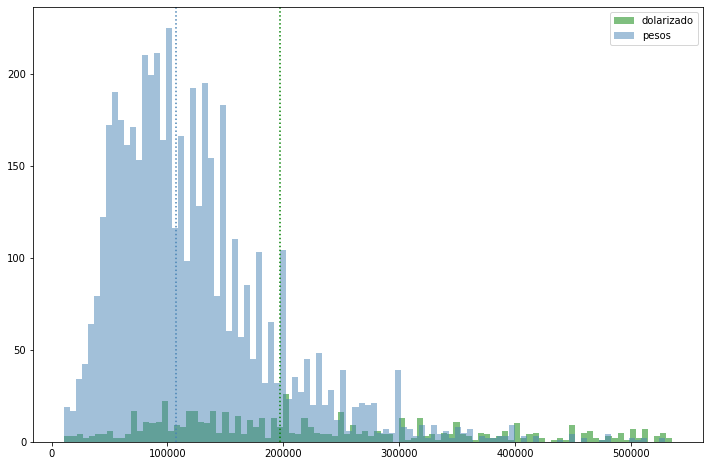

<IPython.core.display.Javascript object>

In [56]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
_dolar = dataframe[
    dataframe.sueldo_dolarizado
].salario_mensual_o_retiro_bruto_en_tu_moneda_local
_no_dolar = dataframe[
    ~dataframe.sueldo_dolarizado
].salario_mensual_o_retiro_bruto_en_tu_moneda_local
ax.hist(_dolar, bins=100, label="dolarizado", alpha=0.5, color="green")
ax.hist(_no_dolar, bins=100, label="pesos", alpha=0.5, color="steelblue")
ax.axvline(_dolar.median(), color="green", linestyle="dotted")
ax.axvline(_no_dolar.median(), color="steelblue", linestyle="dotted")
ax.legend()

### 2.3. Género

#### 2.3.1. Preprocesamiento

In [57]:
# gender simplification
df = dataframe

ix_varon = (df["me_identifico"] == "Varón Cis") | (df.me_identifico == "Varón Trans")
ix_mujer = (df.me_identifico == "Mujer Cis") | (df.me_identifico == "Mujer Trans")

mask = ["Varón Cis", "Mujer Cis", "No binarie", "Prefiero no decir"]
ix_rest = ~df.me_identifico.isin(mask)

df["me_id"] = df.me_identifico
df.loc[ix_varon, "me_id"] = "Varón"
df.loc[ix_mujer, "me_id"] = "Mujer"
df.loc[ix_rest, "me_id"] = "Otro"

<IPython.core.display.Javascript object>

#### 2.3.2. Preparación

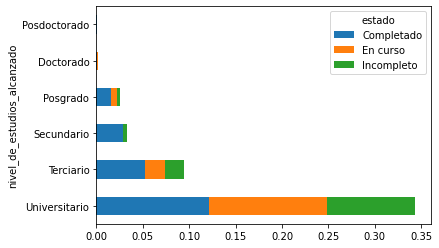

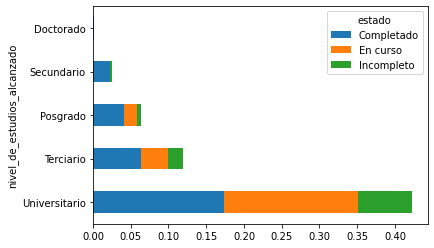

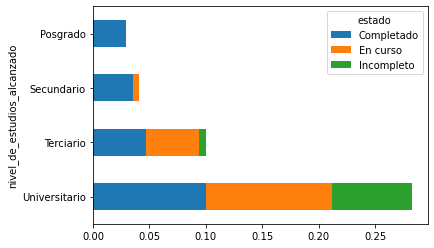

<IPython.core.display.Javascript object>

In [58]:
df = dataframe.query('me_id == "Varón"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_hombre_stacked"] = to_rechart(df)

df = dataframe.query('me_id == "Mujer"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)
charts["education_mujer_stacked"] = to_rechart(df)

df = dataframe.query('me_id == "Otro"')
df = df.groupby(["nivel_de_estudios_alcanzado", "estado"])[
    "nivel_de_estudios_alcanzado"
].count().unstack("estado").fillna(0).sort_values(
    by=["Completado"], ascending=False
).sort_values(
    by=["En curso"], ascending=False
) / len(
    df
)
df.plot(kind="barh", stacked=True, logx=False)

charts["education_otros_stacked"] = to_rechart(df)

#### 2.3.3. Salarios

In [59]:
df = dataframe["trabajo_de"].value_counts(normalize=True, sort=True)
top_roles = df[:26].index

top_salary_roles = (
    dataframe.query("trabajo_de in @top_roles")
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)
top_salary_roles_mujer = (
    dataframe.query('trabajo_de in @top_roles & me_id == "Mujer"')
    .groupby(["trabajo_de"])
    .median()["salario_mensual_o_retiro_bruto_en_tu_moneda_local"]
    .fillna(0)
    .sort_values(0, ascending=False)
    .index.tolist()
)

# Roles mejores pagos en los que no se encuentran mujeres
display([rol for rol in top_salary_roles if rol not in top_salary_roles_mujer])

['DBA', 'Middleware']

<IPython.core.display.Javascript object>

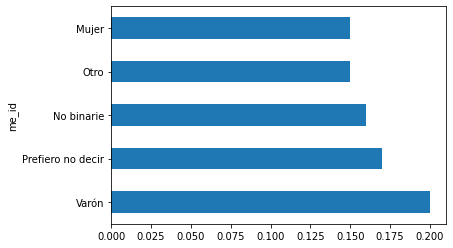

<IPython.core.display.Javascript object>

In [60]:
df = (
    dataframe.groupby(["me_id"])
    .median()
    .unstack()["de_que_fue_el_ajuste_total"]
    .sort_values(ascending=False)
    / 100
)

df.plot(kind="barh")
charts["gender_salary_adjustment"] = to_rechart(df)

#### 2.3.4. Experiencia

me_id,Mujer,No binarie,Otro,Prefiero no decir,Varón
actividad_principal,,,,,
Otras industrias,0.112965,0.003209,0.033376,0.037869,0.812580
Producto basado en Software,0.156385,0.006695,0.025825,0.036346,0.774749
Servicios / Consultoría de Software / Digital,0.176166,0.004663,0.033161,0.045078,0.740933


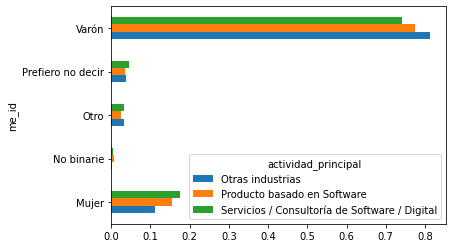

<IPython.core.display.Javascript object>

In [61]:
df = dataframe
df = (
    df.groupby(["actividad_principal", "me_id"])
    .agg({"me_id": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_id")
)
df.columns = df.columns.droplevel(0)

display(df)
df.T.plot(kind="barh")
charts["actividad_principal_gender_percent"] = to_rechart(df)

me_id,Mujer,No binarie,Otro,Prefiero no decir,Varón
anos_de_experiencia_fibo,,,,,
0-1,0.225597,0.006508,0.030369,0.036876,0.700651
2,0.196787,0.014056,0.038153,0.036145,0.714859
3,0.144928,0.006211,0.031056,0.045549,0.772257
4-5,0.146853,0.006993,0.020979,0.029138,0.796037
6-8,0.138070,0.002681,0.032172,0.044236,0.782842
9-13,0.125490,0.003922,0.028431,0.046078,0.796078
14-21,0.096176,0.001159,0.025492,0.041715,0.835458
22-55,0.088889,0.000000,0.048148,0.048148,0.814815


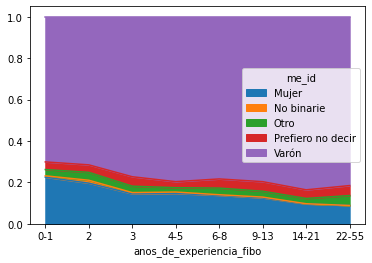

<IPython.core.display.Javascript object>

In [62]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id"])
    .agg({"me_id": "count"})
    .groupby(level=0)
    .apply(lambda x: x / float(x.sum()))
    .unstack("me_id")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="area")
charts["experience_gender_percent"] = to_rechart(df)

me_id,Mujer,No binarie,Otro,Prefiero no decir,Varón
anos_de_experiencia_fibo,,,,,
0-1,69231.5,60000.0,61000.0,65000.0,70000.0
2,83000.0,132000.0,84000.0,70200.0,90000.0
3,81500.0,95000.0,100000.0,115790.5,105000.0
4-5,101500.0,140000.0,117000.0,140000.0,120000.0
6-8,125000.0,170000.0,111000.0,100000.0,136099.0
9-13,145332.0,165000.0,127000.0,130000.0,140000.0
14-21,135000.0,53000.0,122500.0,160000.0,142500.0
22-55,127000.0,0.0,126000.0,177000.0,154027.0


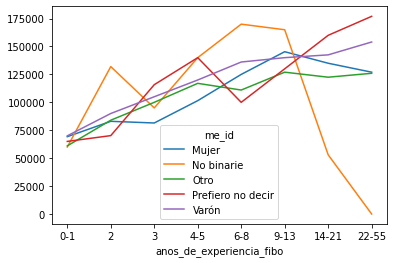

<IPython.core.display.Javascript object>

In [63]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id"])
    .agg({"salario_mensual_o_retiro_bruto_en_tu_moneda_local": "median"})
    .unstack("me_id")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_salary_median"] = to_rechart(df)

me_id,Mujer,No binarie,Otro,Prefiero no decir,Varón
anos_de_experiencia_fibo,,,,,
0-1,2.461538,3.000000,2.357143,2.235294,2.535604
2,2.612245,2.714286,2.157895,2.277778,2.598315
3,2.557143,3.000000,2.400000,2.590909,2.635389
4-5,2.515873,3.000000,2.555556,2.560000,2.622255
6-8,2.611650,2.000000,2.458333,2.515152,2.655822
9-13,2.609375,2.500000,2.379310,2.297872,2.625616
14-21,2.590361,1.000000,2.545455,2.500000,2.513176
22-55,2.541667,0.000000,2.615385,2.384615,2.581818


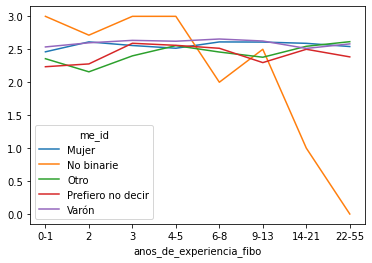

<IPython.core.display.Javascript object>

In [64]:
df = dataframe.copy()
df["anos_de_experiencia_fibo"] = pd.cut(
    df["anos_de_experiencia"].values,
    [0, 1, 2, 3, 5, 8, 13, 21, 55],
    labels=["0-1", "2", "3", "4-5", "6-8", "9-13", "14-21", "22-55"],
)
df = (
    df.groupby(["anos_de_experiencia_fibo", "me_id"])
    .agg({"que_tan_conforme_estas_con_tu_sueldo": "mean"})
    .unstack("me_id")
    .fillna(0)
)
df.columns = df.columns.droplevel(0)
display(df)
df.plot(kind="line")
charts["experience_gender_conformidad_mean"] = to_rechart(df)

#### 2.3.5. Discapacidad

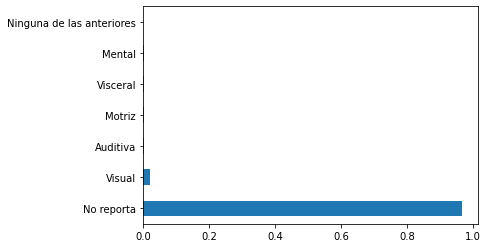

<IPython.core.display.Javascript object>

In [65]:
df = dataframe["tenes_algun_tipo_de_discapacidad"].fillna("No reporta").value_counts(
    normalize=False, sort=True
) / len(dataframe)

# df = dataframe['tenes_algun_tipo_de_discapacidad'].value_counts(normalize=True, sort=True)#.to_frame()

df[:7].plot(kind="barh")
charts["discapacidad_percent"] = to_rechart(df, 7)

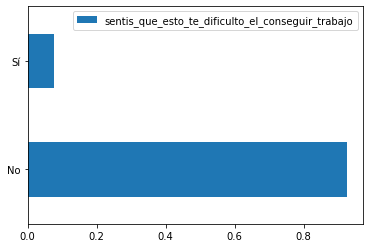

<IPython.core.display.Javascript object>

In [66]:
# Quienes respondieron Sí o No, son quienes contestaron sobre discapacidad.  El resto es None
df = (
    dataframe["sentis_que_esto_te_dificulto_el_conseguir_trabajo"]
    .value_counts(normalize=True, sort=True)
    .to_frame()
)

df.plot(kind="barh")
charts["discapacidad_dificultad_percent"] = to_rechart(df)

### 2.4. Tecnología

#### 2.4.1. Plataformas más populares

'reduced in 0.004975'

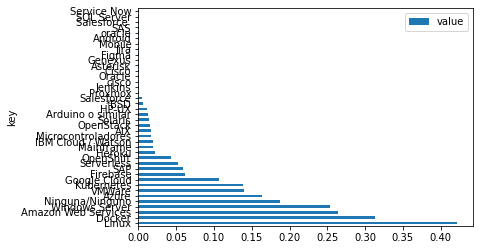

<IPython.core.display.Javascript object>

In [67]:
df = (
    dataframe["plataformas"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "Google Cloud Platform/App Engine": "Google Cloud",
        "Sap": "SAP",
        "crm": "CRM",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["plataformas"] = to_rechart(df[:40])

#### 2.4.2. Lenguajes de Programación más populares

'reduced in 0.037383'

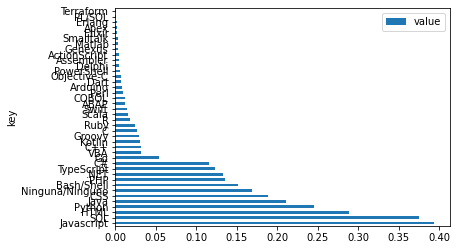

<IPython.core.display.Javascript object>

In [68]:
df = (
    dataframe["lenguajes_de_programacion_o_tecnologias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "powershell": "PowerShell",
        "cobol": "COBOL",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:40].plot.barh()
charts["lenguajes_de_programacion"] = to_rechart(df[:40])

#### 2.4.3. Frameworks, Herramientas y Librerías más populares

'reduced in 0.044643'

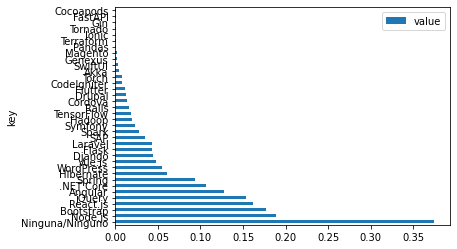

<IPython.core.display.Javascript object>

In [69]:
df = (
    dataframe["frameworksherramientas_y_librerias"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(node).*$": "Node.js",
        ".*Angular.*$": "Angular",
        ".*React.*$": "React.js",
        ".*Vue.*$": "Vue.js",
        ".*jquery.*$": "jQuery",
        ".*laravel.*$": "Laravel",
        ".*codeigniter.*$": "CodeIgniter",
        ".*struts.*$": "Struts",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(nada|no|ningun[ao]|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:36].plot.barh()
charts["frameworksherramientas_y_librerias"] = to_rechart(df[:36])

#### 2.4.4. Bases de Datos más populares

'reduced in 0.045113'

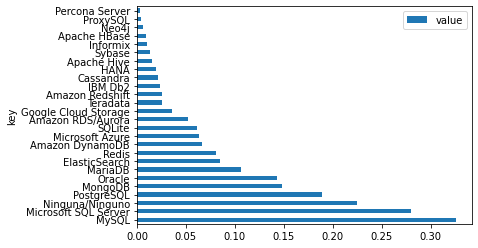

<IPython.core.display.Javascript object>

In [70]:
df = (
    dataframe["bases_de_datos"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(sybase).*$": "Sybase",
        "Microsoft Azure \(Tables": "Microsoft Azure",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
        "^(SQL|CosmosDB|etc\)|otros?|0|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["bases_de_datos"] = to_rechart(df[:26])

#### 2.4.5. Herramientas de QA / Testing más populares

'reduced in 0.123711'

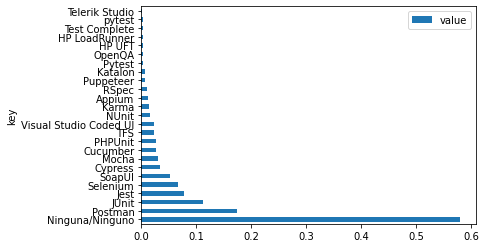

<IPython.core.display.Javascript object>

In [71]:
df = (
    dataframe["qa_testing"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*(ningun[oa]|no|nada|otros?|0|\.).*$": "DELETEME",
        ".*(junit).*$": "JUnit",
        ".*(jest).*$": "Jest",
        "Ninguna de las anteriores": "Ninguna/Ninguno",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:25].plot.barh()
charts["qa_testing"] = to_rechart(df[:25])

#### 2.4.6. IDEs más populares

'reduced in 0.121019'

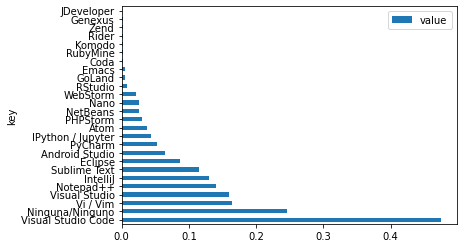

<IPython.core.display.Javascript object>

In [72]:
df = (
    dataframe["ides"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        "^.*(Visual Studio|VS).*$": "Visual Studio",
        "^.*(Visual Studio Code|VS ?Code|Code).*$": "Visual Studio Code",
        ".*(Sublime)( Text)?.*$": "Sublime Text",
        ".*(webstorm).*$": "WebStorm",
        "^(vi|vim)$": "Vi / Vim",
        "^(jdeveloper)$": "JDeveloper",
        "^(goland)$": "GoLand",
        "^(neovim)$": "NeoVim",
        "IBM integración toolkit": "IBM Integration Bus",
        "^(rubymine)$": "RubyMine",
        "Ninguno de los anteriores": "Ninguna/Ninguno",
        "^(no( uso.*| util.*)?|none|ningun[ao]|0|No s[eé]|nada|-|\.)$": "DELETEME",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["ides"] = to_rechart(df[:26])

### 2.5. Trabajo

#### 2.5.1. Tipos de contrato

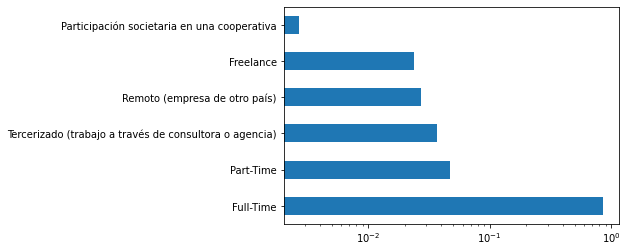

<IPython.core.display.Javascript object>

In [73]:
df = dataframe["tipo_de_contrato"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["tipo_de_contrato_percent"] = to_rechart(df)

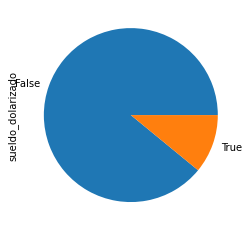

<IPython.core.display.Javascript object>

In [74]:
df = dataframe["sueldo_dolarizado"].value_counts(normalize=True, sort=True)
df.plot.pie()
charts["sueldo_dolarizado_percent"] = to_rechart(df)

#### 2.5.2. Compensación

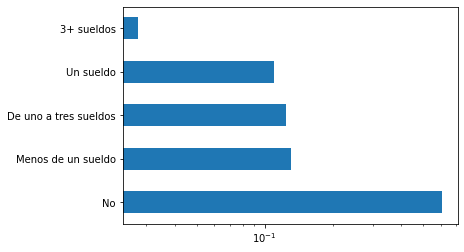

<IPython.core.display.Javascript object>

In [75]:
df = dataframe["recibis_algun_tipo_de_bono"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=True)
charts["recibis_algun_tipo_de_bono"] = to_rechart(df)

'reduced in 0.121212'

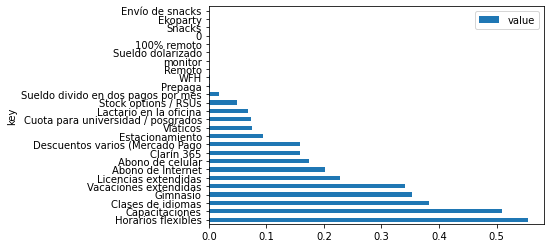

<IPython.core.display.Javascript object>

In [76]:
df = (
    dataframe["beneficios_extra"]
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
df.reset_index(level=0, inplace=True)

df = normalize_dataframe_column(
    df,
    "key",
    {
        ".*Vacaciones flexibles.*$": "Vacaciones extendidas",
        ".*Licencias?.*$": "Licencias extendidas",
        "horarios? flexibles?$": "Horarios flexibles",
        "(.*capacitaci[oó]n(es)?.*|.*cursos?.*)$": "Capacitaciones",
        "bebidas?$": "Bebidas",
        "(golosinas?|snac?ks?)$": "Snacks",
        "(Descuentos varios \(Clarín 365)$": "Descuentos varios",
        "(etc\)|Club La Nación)$": "DELETEME",
        "(no|.*Nada.*|Ning[uú]n[ao]?( de las anteriores)?)$": "DELETEME",
        "(.*prepaga.*|OSDE|.*obra social.*)$": "Prepaga",
        "(frut[ao]s?)$": "Frutas",
        "(facturas?)": "Facturas",
        "(.*home off?ice.*|.*WFH.*|.*home work.*)$": "WFH",
        "(.*d[oó]lares.*|Sueldo dolarizado)$": "Sueldo dolarizado",
        "(.*gimnasio.*|.*gym.*)$": "Gimnasio",
        "(.*cochera.*|.*estacionamiento.*)$": "Estacionamiento",
        "(.*combustibles?.*|.*vi[aá]ticos?.*|.*cabify.*|.*transporte.*|.*remis.*)$": "Viáticos",
        "(.*sueldos? ex.*)$": "Sueldos extra",
        "(.*eventos?.*|entradas?)$": "Eventos",
        "(.*pileta)$": "Pileta",
    },
)

# Reagrupamos valores, sumándolos, luego de haber normalizado
df = df.query('key != "DELETEME"').groupby("key").sum()["value"].sort_values(
    ascending=False
).to_frame() / len(dataframe)

df[:26].plot.barh()
charts["beneficios_extra"] = to_rechart(df[:26])

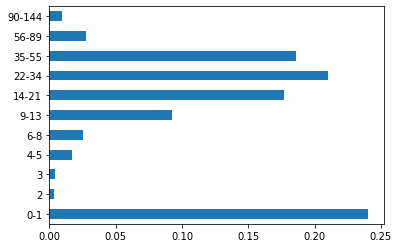

<IPython.core.display.Javascript object>

In [77]:
df = dataframe["de_que_fue_el_ajuste_total"].copy()
df = df.groupby(
    pd.cut(
        df.values,
        [0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144],
        labels=[
            "0-1",
            "2",
            "3",
            "4-5",
            "6-8",
            "9-13",
            "14-21",
            "22-34",
            "35-55",
            "56-89",
            "90-144",
        ],
        include_lowest=True,
    )
).count() / len(df)

df.plot.barh()
charts["de_que_fue_el_ajuste"] = to_rechart(df.sort_index())

#### 2.5.3. Características de la Empresa

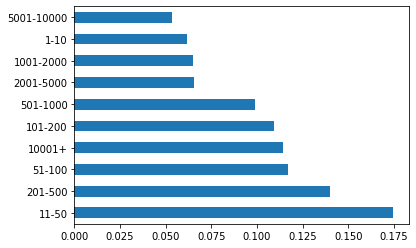

<IPython.core.display.Javascript object>

In [78]:
df = dataframe["cantidad_de_personas_en_tu_organizacion"].value_counts(
    normalize=True, sort=True
)

df.plot(kind="barh", logx=False)
charts["cantidad_de_personas"] = to_rechart(df)

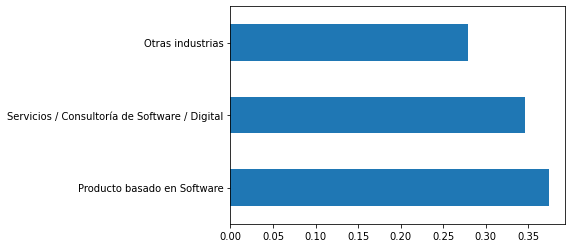

<IPython.core.display.Javascript object>

In [79]:
df = dataframe["actividad_principal"].value_counts(normalize=True, sort=True)

df.plot(kind="barh", logx=False)
charts["actividad_principal"] = to_rechart(df)

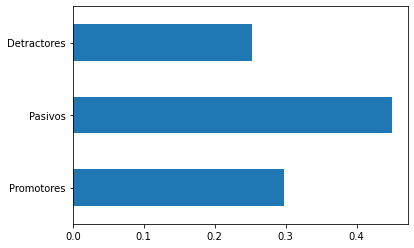

<IPython.core.display.Javascript object>

In [80]:
df = dataframe["la_recomendas_como_un_buen_lugar_para_trabajar"].copy()
# https://es.wikipedia.org/wiki/Net_Promoter_Score
df = df.groupby(
    pd.cut(df.values, [0, 6, 8, 10], labels=["Detractores", "Pasivos", "Promotores"])
).count() / len(df)
df = df.iloc[::-1]  # reverse order

df.plot.barh()
charts["la_recomendas_como_un_buen_lugar_para_trabajar"] = to_rechart(df)

## 3. Publicación

In [81]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=True),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 6088, "total_analyzed_surveyed": 5579, "regions_percent": {"data": [{"name": "Ciudad Aut\\u00f3noma de Buenos Aires", "value": 0.59473}, {"name": "Buenos Aires", "value": 0.17494}, {"name": "C\\u00f3rdoba", "value": 0.08514}, {"name": "Santa Fe", "value": 0.05951}, {"name": "Mendoza", "value": 0.01846}, {"name": "Entre R\\u00edos", "value": 0.00789}, {"name": "Tucum\\u00e1n", "value": 0.00753}, {"name": "Chaco", "value": 0.00663}, {"name": "Neuqu\\u00e9n", "value": 0.00645}, {"name": "R\\u00edo Negro", "value": 0.00627}, {"name": "Misiones", "value": 0.0052}, {"name": "Jujuy", "value": 0.00376}, {"name": "Corrientes", "value": 0.00376}, {"name": "San Juan", "value": 0.00341}, {"name": "Salta", "value": 0.00323}, {"name": "San Luis", "value": 0.00323}, {"name": "Chubut", "value": 0.00305}, {"name": "La Rioja", "value": 0.00179}, {"name": "La Pampa", "value": 0.00143}, {"name": "Tierra del Fuego", "value": 0.00125}, {"name": "Santiago del Estero", "value": 0.00125}, {

<IPython.core.display.Javascript object>